In [1]:
import torch
from data import run_length_encoding
from data import event_codec
from data import vocabularies
from data import spectrograms
from data import note_sequences
import note_seq
import numpy as np
import pretty_midi
import sklearn
from typing import Callable, Mapping, Optional, Sequence, Tuple
import editdistance
import mir_eval
import librosa
from utils import _audio_to_frames, AttrDict
from model.ListenAttendSpell import ListenAttendSpell 
from tqdm import tqdm
import yaml
import functools
from evaluation import *
import os 

import librosa.display
import matplotlib.pyplot as plt

In [2]:
with open('config/model.yaml', 'r') as f:
    file_config = yaml.safe_load(f)
config = AttrDict(file_config)
config.training.beam_size = 2
codec = event_codec.Codec(
        max_shift_steps=300,
        steps_per_second=100,
        event_ranges=[
                event_codec.EventRange('pitch', note_seq.MIN_MIDI_PITCH,
                            note_seq.MAX_MIDI_PITCH),
                event_codec.EventRange('velocity', 0, 127)
        ])
vocab = vocabularies.vocabulary_from_codec(codec)
spectrogram_config = spectrograms.SpectrogramConfig()

In [3]:
model_states = torch.load("/home/ubuntu/seq2seq-music-transcription/MAESTRO/maestro/exp/las_model/las_model.epoch6799.chkpt", map_location=torch.device('cuda'))
model = ListenAttendSpell.load_model(model_states)

In [14]:
final_files, midi_files = get_test_files('/home/ubuntu/seq2seq-music-transcription/data/MAESTRO/maestro-v1.0.0.csv')

In [20]:
audio_path = final_files[0].replace("_test.pt", ".wav")

In [21]:
segmented_frames, segmented_times = segmentize_audio(audio_path, spectrogram_config)
segmented_spec=[]
for i in segmented_frames:
    j = make_spectrogram(i, spectrogram_config)
    segmented_spec.append(j)

In [22]:
pred_ns = make_pred_ns(segmented_spec, segmented_times, codec, vocab, model, config)

 54%|█████▍    | 135/251 [04:20<03:43,  1.93s/it]


KeyboardInterrupt: 

In [15]:
midi_path = '/Users/donghyunlee/Desktop/encoder_decoder_model/test_data/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.midi'
ref_ns = note_seq.midi_file_to_note_sequence(midi_path)
note_sequences.validate_note_sequence(ref_ns)
ref_ns = note_seq.apply_sustain_control_changes(ref_ns)
output_1 = evaluation_mir_eval(ref_ns, pred_ns)

In [16]:
output_1

{'Onset precision': 0.9843219231774236,
 'Onset recall': 0.9543957436027363,
 'Onset F1': 0.9691278621044507,
 'Onset + offset precision': 0.7123072903057225,
 'Onset + offset recall': 0.6906511274385609,
 'Onset + offset F1': 0.7013120658605608,
 'Onset + velocity precision': 0.9619806637052521,
 'Onset + velocity recall': 0.932733721814036,
 'Onset + velocity F1': 0.9471314638538719,
 'Onset + offset + velocity precision': 0.6925790436373138,
 'Onset + offset + velocity recall': 0.6715226754497087,
 'Onset + offset + velocity F1': 0.6818883457679443}

# BATCH TESTING

In [4]:
final_files, midi_files = get_test_files('/home/ubuntu/seq2seq-music-transcription/data/MAESTRO/maestro-v1.0.0.csv')

In [5]:
model.cuda()
model.eval()

ListenAttendSpell(
  (encoder): Encoder(
    (rnn): LSTM(512, 1024, num_layers=4, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(560, 512)
    (rnn): ModuleList(
      (0): LSTMCell(2560, 2048)
    )
    (attention): DotProductAttention()
    (linear): Sequential(
      (0): Linear(in_features=4096, out_features=2048, bias=True)
      (1): Tanh()
      (2): Linear(in_features=2048, out_features=560, bias=True)
    )
    (loss): CrossEntropyLoss()
  )
)

In [6]:
test_file = final_files[4]
data = torch.load(test_file)

In [7]:
greedy_batch_ns = make_batch_pred_ns(data, config, codec, vocab, model, is_gpu=True)

In [8]:
midi_path = midi_files[4]
ref_ns = note_seq.midi_file_to_note_sequence(midi_path)
note_sequences.validate_note_sequence(ref_ns)
ref_ns = note_seq.apply_sustain_control_changes(ref_ns)
output_1 = evaluation_mir_eval(ref_ns, greedy_batch_ns)

/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/mir_eval/transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, intercept = np.linalg.lstsq(


In [9]:
output_1

{'Onset precision': 0.9500348594004183,
 'Onset recall': 0.8538011695906432,
 'Onset F1': 0.899351006489935,
 'Onset + offset precision': 0.6943992563327911,
 'Onset + offset recall': 0.6240601503759399,
 'Onset + offset F1': 0.6573534264657354,
 'Onset + velocity precision': 0.9140134789681618,
 'Onset + velocity recall': 0.8214285714285714,
 'Onset + velocity F1': 0.8652513474865251,
 'Onset + offset + velocity precision': 0.6693004880316059,
 'Onset + offset + velocity recall': 0.6015037593984962,
 'Onset + offset + velocity F1': 0.6335936640633594}

In [6]:
final_output = []
for audio, midi in tqdm(zip(final_files, midi_files), total=len(final_files)):
    data = torch.load(audio)
    greedy_batch_ns = make_batch_pred_ns(data, config, codec, vocab, model, is_gpu=True)
    midi_path = midi
    ref_ns = note_seq.midi_file_to_note_sequence(midi_path)
    note_sequences.validate_note_sequence(ref_ns)
    ref_ns = note_seq.apply_sustain_control_changes(ref_ns)
    output = evaluation_mir_eval(ref_ns, greedy_batch_ns)
    final_output.append(output)

  0%|          | 0/125 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/mir_eval/transcription_velocity.py:185: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, intercept = np.linalg.lstsq(
100%|██████████| 125/125 [21:38<00:00, 10.39s/it]


In [7]:
onset_f1 = []
onset_offset_f1 = []
onset_offset_velocity_f1 = []

for output in final_output:
    onset_f1.append(output['Onset F1'])
    onset_offset_f1.append(output['Onset + offset F1'])
    onset_offset_velocity_f1.append(output['Onset + offset + velocity F1'])

In [13]:
test = [[0,2,3,4,5,56],[100]]
check = []
for i in test:
    try: 
        test=i.index(100)
        check.append(i)
    except:
        check.append("fuck")
print(check)

['fuck', [100]]


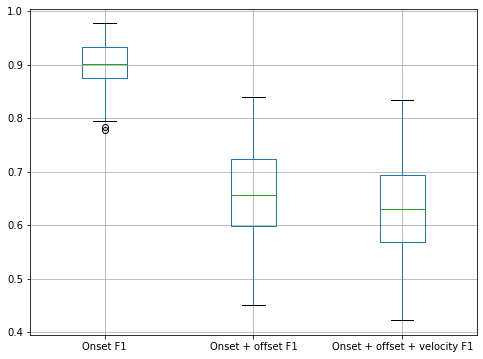

In [10]:
import pandas as pd
plot_data = [onset_f1, onset_offset_f1, onset_offset_velocity_f1]
df = pd.DataFrame(plot_data).transpose()
df.columns= ['Onset F1', 'Onset + offset F1','Onset + offset + velocity F1']
boxplot = df.boxplot(column=['Onset F1', 'Onset + offset F1','Onset + offset + velocity F1'],figsize=(8,6))

In [14]:
info_data = []
for i in plot_data:
    mean = np.mean(i)
    max = np.max(i)
    max_index = np.where(i==max)
    min = np.min(i)
    min_index = np.where(i==min)
    info_data.append([mean,[max, max_index],[min, min_index]])

print(info_data)

[[0.9005913316701326, [0.9769462078182426, (array([88]),)], [0.7780534877309071, (array([33]),)]], [0.6580888297622013, [0.8396271132880392, (array([100]),)], [0.4502847130968024, (array([21]),)]], [0.6359060123798479, [0.8332776478449715, (array([88]),)], [0.4231274638633377, (array([21]),)]]]


In [18]:
print(midi_files[88])
print(midi_files[100])
print(midi_files[33])
print(midi_files[21])
print(onset_f1[21])
print(onset_offset_f1[33])
print(onset_offset_velocity_f1[33])

/home/ubuntu/seq2seq-music-transcription/data/MAESTRO/2017/MIDI-Unprocessed_053_PIANO053_MID--AUDIO-split_07-06-17_Piano-e_3-04_wav--1.midi
/home/ubuntu/seq2seq-music-transcription/data/MAESTRO/2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split_07-07-17_Piano-e_3-02_wav--2.midi
/home/ubuntu/seq2seq-music-transcription/data/MAESTRO/2013/ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_11_R1_2013_wav--4.midi
/home/ubuntu/seq2seq-music-transcription/data/MAESTRO/2008/MIDI-Unprocessed_15_R2_2008_01-04_ORIG_MID--AUDIO_15_R2_2008_wav--4.midi
0.7829610162067455
0.5596912048524952
0.5234812976748461


In [19]:
pm = note_seq.note_sequence_to_pretty_midi(ns)
for inst in pm.instruments:
    inst.is_drum = False

NameError: name 'ns' is not defined

In [20]:
ref_pianoroll = pm.get_piano_roll(fs=62.5)
def plot_piano_roll(pm, start_pitch, end_pitch, fs=62.5):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

plt.figure(figsize=(8, 4))
plot_piano_roll(pm, 0, 127)

NameError: name 'pm' is not defined

In [22]:
check_midi=[33,21,100, 88]
for i in check_midi:
    data = torch.load(final_files[i])
    greedy_batch_ns = make_batch_pred_ns(data, config, codec, vocab, model, is_gpu=True)
    note_seq.note_sequence_to_midi_file(greedy_batch_ns, f"{i}_predicted.mid")

In [ ]:
for audio, midi in tqdm(zip(final_files, midi_files), total=len(final_files)):
    data = torch.load(audio)
    greedy_batch_ns = make_batch_pred_ns(data, config, codec, vocab, model, is_gpu=True)
    midi_path = midi
    ref_ns = note_seq.midi_file_to_note_sequence(midi_path)
    note_sequences.validate_note_sequence(ref_ns)
    ref_ns = note_seq.apply_sustain_control_changes(ref_ns)
    output = evaluation_mir_eval(ref_ns, greedy_batch_ns)
    final_output.append(output)